In [14]:
# hide
%reload_ext autoreload
%autoreload 2

In [15]:
from dataFunction import *
# import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from HE_functions import *
from dataFunction import *
from typing import Generator
import tenseal as ts
from lrClass import LR
from simulationDataUtils import *
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as st
from run_simulations import run_simulations

random.seed(11007303)
np.random.seed(2021)

In [16]:
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [17]:
cleveland = "processed.cleveland.data"
switzerland = "processed.switzerland.data"
va = "processed.va.data"
hungarian = "reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)


In [18]:
def average_state_dict_test(state_dicts, len_dict, keys):
    result = {}
    # result = copy.deepcopy(state_dicts[0])
    for i, state_dict in enumerate(state_dicts):
        for key in keys:
            if i == 0:
                result[key] =  state_dict[key]*(len_dict[i]/sum(len_dict))
            else:
                result[key] += state_dict[key]*(len_dict[i]/sum(len_dict))
    return result

In [19]:
def FL_proces_test(clients, validation_X_set, validation_y_set, ctx_eval, glob_model, iters, simulation= False):
    loss_train = []
    net_best = None
    best_acc = None
    best_epoch = None
    results = []
    min_loss_client = []
    glob_model.eval()
    enrypted_state_dicts= None
    acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set, simulation)

    best_acc = acc_test
    for iter in range(iters):
        loss_locals = []
        client_state_dicts = []
        client_len = []
        for client in clients:
            client_model = copy.deepcopy(glob_model)
            client.set_state_dict(client_model.state_dict())
            client_state_dict, loss = train_model_client(client, epochs=40, simulation = simulation)
            
            loss_locals.append(copy.deepcopy(loss))
            min_loss_client.append(min(loss))
            client_state_dicts.append(client_state_dict)
            client_len.append(len(client.y))

        enrypted_state_dicts = encrypt_state_dicts(copy.deepcopy(client_state_dicts), ctx_eval)
        averaged_encrypted_state_dict = average_state_dict_test(enrypted_state_dicts, client_len, [k for k in enrypted_state_dicts[0]])
        decrypted_state_dicts = decrypt_state_dicts(averaged_encrypted_state_dict)
        glob_model.load_state_dict(decrypted_state_dicts)

        loss_avg = sum(min_loss_client) / len(min_loss_client)
        loss_train.append(loss_avg)        
            
        acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set, simulation)

        # print('Round {:3d}, Average loss {:.3f}, Test loss {:.3f}, Test accuracy: {:.2f}'.format(
        #     iter, loss_avg, loss_test, acc_test))


        if best_acc is None or acc_test > best_acc:
            net_best = copy.deepcopy(glob_model)
            best_acc = acc_test
            best_epoch = iter

        results.append(np.array([iter, loss_avg, loss_test, acc_test, best_acc]))
        final_results = np.array(results)
        final_results = pd.DataFrame(final_results, columns=['epoch', 'loss_avg', 'loss_test', 'acc_test', 'best_acc'])

    # print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))    
    return best_epoch, best_acc, glob_model.state_dict(), final_results

In [20]:
df_dict_W ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_W = []

for i in list(df_dict_W.keys()):
    df = df_dict_W.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak', 'Cholesterol']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_W = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_W)
    lr = 0.2
    clients_W.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_W = KL_matrices_disc_cont(clients_W, cat_bin_features, numeric_feature_names)
KL_mean_W = (np.array(KL_W)[np.triu_indices(len(clients_W), k=1)].mean() + np.array(KL_W)[np.tril_indices(len(clients_W), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_W:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model = LR(len(clients_W[0].X.columns))
val_x, val_y = make_validation_sets(clients_W)

best_epoch_W, best_acc_W, model_dict_W, final_results_W = FL_proces_test(clients_W, val_x, val_y, ctx_eval, glob_model_W, 1000, False)
print(df_dict_W.keys())
print(clients_W[0].X.columns)
print(KL_W)
print('KL FL mean: {}'.format(KL_mean_W))
print('Best model, iter: {}, acc: {}'.format(best_epoch_W, best_acc_W))  


dict_keys(['Cleveland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2
0  0.000000  2.195766  2.491469
1  2.578414  0.000000  2.326614
2  1.561995  1.988351  0.000000
KL FL mean: 2.190434912504877
Best model, iter: 930, acc: 0.7933333516120911


In [21]:
df_dict_SW ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_SW = []

for i in list(df_dict_SW.keys()):
    df = df_dict_SW.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names_SW = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names_SW:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_SW = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_SW)
    lr = 0.1
    clients_SW.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_SW = KL_matrices_disc_cont(clients_SW, cat_bin_features, numeric_feature_names_SW)
KL_mean_S = (np.array(KL_SW)[np.triu_indices(len(clients_SW), k=1)].mean() + np.array(KL_SW)[np.tril_indices(len(clients_SW), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_SW:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model_S = LR(len(clients_SW[0].X.columns))
val_x_S, val_y_S = make_validation_sets(clients_SW)

best_epoch_SW, best_acc_SW, model_dict_SW, final_results_SW = FL_proces_test(clients_SW, val_x_S, val_y_S, ctx_eval, glob_model_SW, 1000, False)
print(df_dict_SW.keys())
print(clients_SW[0].X.columns)
print(KL_SW)
print('KL FL mean: {}'.format(KL_mean_S))
print('Best model, iter: {}, acc: {}'.format(best_epoch_SW, best_acc_SW))  


dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'FastingBS', 'MaxHR', 'ExerciseAngina',
       'Oldpeak', 'ChestPainType_1', 'ChestPainType_4', 'ChestPainType_3',
       'ChestPainType_2', 'RestingECG_2', 'RestingECG_0', 'RestingECG_1',
       'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2         3
0  0.000000  1.735963  2.183113  2.466082
1  1.591768  0.000000  0.709178  1.352810
2  2.558419  0.878337  0.000000  2.320192
3  1.539079  1.345990  1.981744  0.000000
KL FL mean: 1.7218895712985067
Best model, iter: 12, acc: 0.7599999904632568


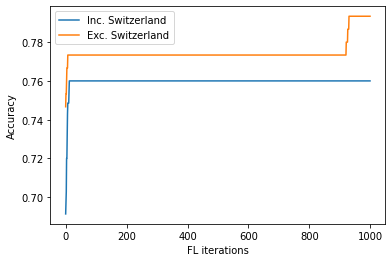

In [22]:
plt.plot(final_results_SW.best_acc, label= 'Inc. Switzerland')
plt.plot(final_results_W.best_acc, label= 'Exc. Switzerland')
plt.ylabel('Accuracy')
plt.xlabel('FL iterations')
plt.legend()

# plt.savefig('images/Accuracy_Healthcare',bbox_inches='tight',  dpi=300)
# plt.savefig('/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_latex/images/Accuracy_Healthcare', bbox_inches='tight',  dpi=300)
plt.show()

In [23]:
df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients = []

for i in list(df_dict.keys()):
    df = df_dict.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak', 'Cholesterol']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model)
    lr = 0.1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL = KL_matrices_disc_cont(clients, cat_bin_features, numeric_feature_names)
KL_mean = (np.array(KL)[np.triu_indices(len(clients), k=1)].mean() + np.array(KL)[np.tril_indices(len(clients), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model = LR(len(clients[0].X.columns))
val_x, val_y = make_validation_sets(clients)

best_epoch, best_acc, model_dict, final_results = FL_proces(clients, val_x, val_y, ctx_eval, glob_model, 1000, False)
print(df_dict.keys())
print(clients[0].X.columns)
print(KL)
print('KL FL mean: {}'.format(KL_mean))
print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  


dict_keys(['Cleveland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2
0  0.000000  2.195766  2.491469
1  2.578414  0.000000  2.326614
2  1.561995  1.988351  0.000000
KL FL mean: 2.190434912504877
Best model, iter: 25, acc: 0.8066666722297668


In [62]:
df_dict_S ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_S = []

for i in list(df_dict_S.keys()):
    df = df_dict_S.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names_S = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names_S:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_S = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_S)
    lr = 0.4
    clients_S.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_S = KL_matrices_disc_cont(clients_S, cat_bin_features, numeric_feature_names_S)
KL_mean_S = (np.array(KL_S)[np.triu_indices(len(clients_S), k=1)].mean() + np.array(KL_S)[np.tril_indices(len(clients_S), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_S:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model_S = LR(len(clients_S[0].X.columns))
val_x_S, val_y_S = make_validation_sets(clients_S)

best_epoch_S, best_acc_S, model_dict_S, final_results_S = FL_proces(clients_S, val_x_S, val_y_S, ctx_eval, glob_model_S, 1000, False)
print(df_dict_S.keys())
print(clients_S[0].X.columns)
print(KL_S)
print('KL FL mean: {}'.format(KL_mean_S))
print('Best model, iter: {}, acc: {}'.format(best_epoch_S, best_acc_S))  


dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0             1         2         3
0  0.000000  1.748567e+00  2.183113  2.466082
1  1.595784 -2.220446e-16  0.706801  1.348535
2  2.558419  8.792501e-01  0.000000  2.320192
3  1.539079  1.348049e+00  1.981744  0.000000
KL FL mean: 1.7229679340099695
Best model, iter: 42, acc: 0.5885714292526245


In [45]:
kl = np.empty((len(clients), len(clients)))
for i in range(len(clients)):
    for j in range(len(clients)):
        kl[i,j] = KL_divergence_disc(prob_discrete_var(clients[i].y),prob_discrete_var(clients[j].y))
kl

array([[0.        , 0.24531176, 0.01974054],
       [0.21714275, 0.        , 0.36644708],
       [0.01926872, 0.40381697, 0.        ]])

In [46]:
kl = np.empty((len(clients_S), len(clients_S)))
for i in range(len(clients_S)):
    for j in range(len(clients_S)):
        kl[i,j] = KL_divergence_disc(prob_discrete_var(clients_S[i].y),prob_discrete_var(clients_S[j].y))
kl

array([[0.        , 0.81187507, 0.24531176, 0.01974054],
       [0.52485028, 0.        , 0.08793214, 0.73572809],
       [0.21714275, 0.1229088 , 0.        , 0.36644708],
       [0.01926872, 1.10395643, 0.40381697, 0.        ]])

In [87]:
# color_map = ["#238b45",
# "#66c2a4",
# "#fb6a4a",
# "#cb181d"]
# from matplotlib import ticker
# color_map = [
# "#e41a1c",
# "#377eb8",
# "#4daf4a",
# "#984ea3"
# ]
# models = ['FedAvg Inc. Switzerland','Weighted FedAvg Inc. Switzerland', 'FedAvg Exc. Switzerland', 'Weighted FedAvg Exc. Switzerland']
# model_acc = [best_acc_S,  best_acc_SW, best_acc, best_acc_W]
# plt.barh( model_acc, models,color=color_map)

# x_pos = [0,10, 20,30]
# plt.xticks(x_pos, models)



# plt.savefig('../images/Accuracy_Healthcare_c',bbox_inches='tight',  dpi=300)
# plt.savefig('/Users/Romy/Documents/Master Thesis/Thesis_latex/images/Accuracy_Healthcare_c', bbox_inches='tight',  dpi=300)
plt.show()

In [243]:
# Plot predicted vs test!

# import plotly.graph_objects as go
# net_best_S.load_state_dict(model_dict_S)
y_pred = net_best(val_x).detach().numpy()
y_test = val_y

y_pred_round =y_pred.round()

fig = go.Figure()
 
 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred_round[:,0],
                    mode='markers',
                    name='Pred'))